In [1]:

from lvmtipo.actors import lvm

from math import nan
from astropy.io import fits

from logging import DEBUG
from sdsstools import get_logger

logger = get_logger("focus")

class Focus():
    def __init__(self, telsubsys):
        self.telsubsys = telsubsys

    async def offset(self, offset):
        try:
           await self.telsubsys.foc.moveRelative(offset)
        
        except Exception as ex:
           logger.error(ex)
           raise ex

    async def nominal(self, temp):
        try:
           temp2focus_pos = temp #TODO: put here a function gathering focus based on temperature.
           await self.telsubsys.foc.moveAbsolute(temp2focus_pos)
        
        except Exception as ex:
           logger.error(ex)
           raise ex

    async def fine(self, exptime):
        try:
            files={}
            for p in [400, 200, 100, 0, -100]: #TODO: implement some focusing that makes sense.
                logger.info(f"Move absolute {p}")
                await self.telsubsys.foc.moveAbsolute(p)
                
                rc = await self.telsubsys.agc.expose(exptime)
                for camera in rc:
                    logger.info(f"{rc[camera]['filename']}")
                    if files.get(camera, None):
                       files[camera].append(rc[camera]["filename"])
                    else:
                       files[camera] = [rc[camera]["filename"]]
            #logger.info(f"{files}")

        except Exception as ex:
           logger.error(ex)
           raise ex



In [3]:
from lvmtipo.actors import lvm

telsys = await lvm.sci.start()
focus = Focus(telsys)

logger.info("focus offset")
await focus.offset(1000)
logger.info("focus fine")
await focus.fine(1)


[INFO]: focus offset
[INFO]: focus fine
[INFO]: Move absolute 400
[INFO]: /data/lvm/sci/agcam/west/20220624/lvm.sci.agcam.west_00000006.fits
[INFO]: Move absolute 200
[INFO]: /data/lvm/sci/agcam/west/20220624/lvm.sci.agcam.west_00000007.fits
[INFO]: Move absolute 100
[INFO]: /data/lvm/sci/agcam/west/20220624/lvm.sci.agcam.west_00000008.fits
[INFO]: Move absolute 0
[INFO]: /data/lvm/sci/agcam/west/20220624/lvm.sci.agcam.west_00000009.fits
[INFO]: Move absolute -100
[INFO]: /data/lvm/sci/agcam/west/20220624/lvm.sci.agcam.west_00000010.fits


In [4]:
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

image_file = get_pkg_data_filename('/data/lvm/sci/agcam/west/20220624/lvm.sci.agcam.west_00000010.fits')



Filename: /data/lvm/sci/agcam/west/20220624/lvm.sci.agcam.west_00000010.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   (400, 275)   int16 (rescales to uint16)   


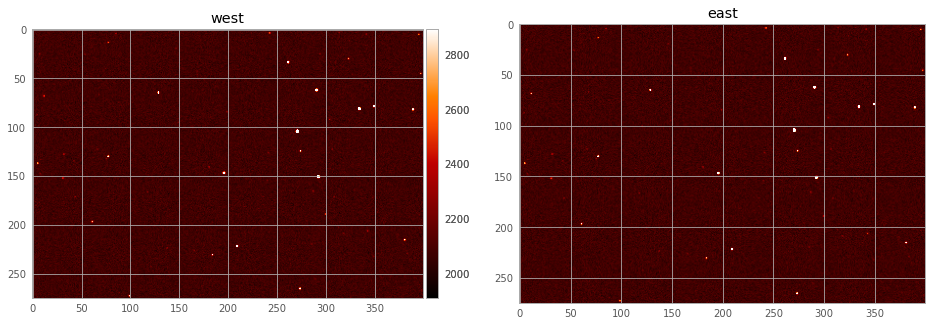

In [54]:
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fits.info(image_file)
data = fits.getdata(image_file, ext=0)

mean, sigma, min, max = np.mean(data), np.std(data), np.min(data), np.max(data)
lperc, uperc = np.percentile(data, 5), np.percentile(data, 99.95)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,20))
ax1.set_title("west")
ax1_im = ax1.imshow(data, vmin=mean-sigma, vmax=uperc)
fig.colorbar(ax1_im, cax=make_axes_locatable(ax1).append_axes('right', size='3%', pad=0.05), orientation='vertical')

ax2.set_title("east")
ax2_im = ax2.imshow(data, vmin=mean-sigma, vmax=uperc)
fig.colorbar(ax2_im, cax=make_axes_locatable(ax1).append_axes('right', size='3%', pad=0.05), orientation='vertical')


In [ ]:
from lvmtipo.actors import lvm

from math import nan
from astropy.io import fits

from logging import DEBUG
from sdsstools import get_logger

logger = get_logger("focus")

def plot_images(data1, data2):
    mean, sigma, min, max = np.mean(data), np.std(data), np.min(data), np.max(data)
    lperc, uperc = np.percentile(data, 5), np.percentile(data, 99.95)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,20))
    ax1.set_title("west")
    ax1_im = ax1.imshow(data1, vmin=mean-sigma, vmax=uperc)
    fig.colorbar(ax1_im, cax=make_axes_locatable(ax1).append_axes('right', size='3%', pad=0.05), orientation='vertical')

    ax2.set_title("east")
    ax2_im = ax2.imshow(data2, vmin=mean-sigma, vmax=uperc)
    fig.colorbar(ax2_im, cax=make_axes_locatable(ax1).append_axes('right', size='3%', pad=0.05), orientation='vertical')


rc = await lvm.sci.agc.expose(exptime)